In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [7]:
# Step 2: Define function to load from a GeoTIFF file
def load_tif(filepath):
    """Load a single-band TIFF file as a numpy array."""
    with rasterio.open(filepath) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        return src.read(1), src.transform, src.crs, extent

In [8]:
def read_kml(ref_tiff_path):
    # Load the KML file
    kml_path = 'dhaka_cIty_gis_project.kml'
    kml_gdf = gpd.read_file(kml_path, driver="KML", allow_unsupported_drivers=True)

    with rasterio.open(ref_tiff_path) as src:
        ref_crs = src.crs

    # Reproject the KML to match the TIFF CRS
    if kml_gdf.crs != ref_crs:
        kml_gdf = kml_gdf.to_crs(ref_crs)

    return kml_gdf

In [9]:
def scale(tiff_image): 
    return -1 + 2 * (tiff_image - tiff_image.min()) / (tiff_image.max() - tiff_image.min())

In [10]:
def calc_mndwi(green_band_path, swir_band_path, year, output_path):
    """
    Calculate and visualize the Modified Normalized Difference Water Index (MNDWI).
    
    Parameters:
    - green_band_path: Path to the Green band (e.g., Band 3 for Landsat 8)
    - swir_band_path: Path to the SWIR band (e.g., Band 6 for Landsat 8)
    - year: Year for labeling the output visualization
    """
    # Step 1: Load Green and SWIR bands
    green, transform, crs, extent = load_tif(green_band_path)
    swir, _, _, _ = load_tif(swir_band_path)
    kml_gdf = read_kml(green_band_path)

    # scale sat image in [0, 1]
    sat_max_value = 10000.0

    green = green.astype('float32') / sat_max_value
    swir = swir.astype('float32') / sat_max_value

    # Step 2: Calculate MNDWI
    mndwi = (green - swir) / (green + swir)

    mndwi = scale(mndwi)

    # Step 3: Plot the MNDWI result
    plt.figure(figsize=(8, 6))
    plt.imshow(mndwi, cmap='RdYlGn', vmin=-1, vmax=1, extent=extent)
    plt.colorbar(label="MNDWI")
    plt.title(f"Modified Normalized Difference Water Index (MNDWI) {year}")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    
    # Overlay the KML polygons
    kml_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=6)

    output_path = output_path + year + "/MNWDI_" + year
    output_tiff = output_path + ".tif"
    output_png = output_path + ".png"

     # Save NDBI as GeoTIFF
    metadata = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': mndwi.shape[1],
        'height': mndwi.shape[0],
        'count': 1,
        'crs': crs,
        'transform': transform,
    }
    with rasterio.open(output_tiff, 'w', **metadata) as dst:
        dst.write(mndwi.astype('float32'), 1)  # Save as first band

    plt.savefig(output_png, dpi=300, bbox_inches='tight')

    plt.show()
    
    print(f"MNWDI saved to {output_path}")

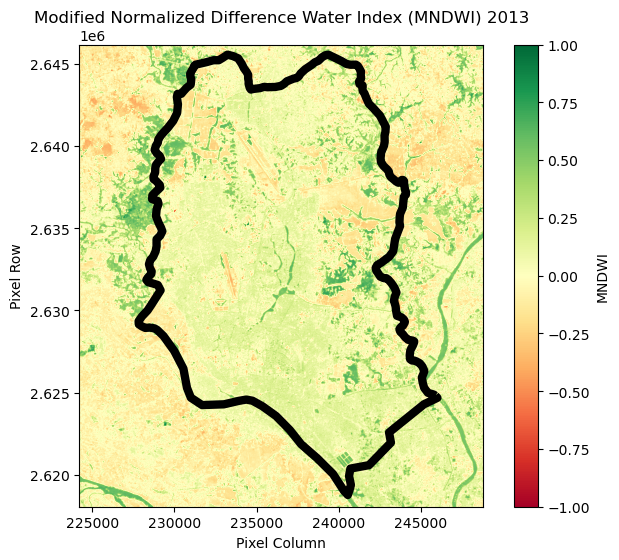

MNWDI saved to ./Landsat8/output/2013/MNWDI_2013


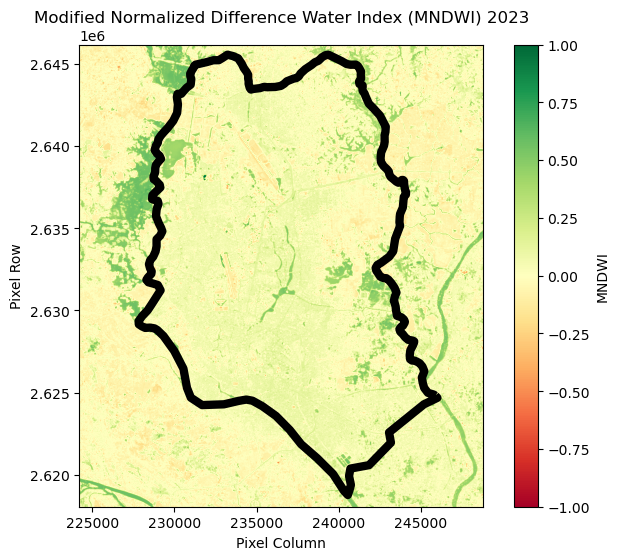

MNWDI saved to ./Landsat8/output/2023/MNWDI_2023


In [11]:
# Paths to data
ROOT = './Landsat8/cropped_bbox/'
OUPUT = './Landsat8/output/'

# MNDWI calculation for 2013
green_band_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B3.TIF'
swir_band_path_2013 = ROOT + '2013/LC08_L2SP_137044_20131224_20200912_02_T1_SR_B6.TIF'
calc_mndwi(green_band_path_2013, swir_band_path_2013, '2013',OUPUT)

# MNDWI calculation for 2023
green_band_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B3.TIF'
swir_band_path_2023 = ROOT + '2023/LC08_L2SP_137044_20231102_20231109_02_T1_SR_B6.TIF'
calc_mndwi(green_band_path_2023, swir_band_path_2023, '2023', OUPUT)

